### Import library

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
import cv2
import random
import sklearn
import tensorflow as tf
from tensorflow import keras
import os
import PIL
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping

### Load dataset

In [2]:
path_normal = "../input/covid19-radiography-database/COVID-19_Radiography_Dataset/Normal/images"
path_covid = "../input/covid19-radiography-database/COVID-19_Radiography_Dataset/COVID/images"
path_lung_opacity = "../input/covid19-radiography-database/COVID-19_Radiography_Dataset/Lung_Opacity/images"
path_viral_pneumonia = "../input/covid19-radiography-database/COVID-19_Radiography_Dataset/Viral Pneumonia/images"

len_normal = len(os.listdir(path_normal))
len_covid = len(os.listdir(path_covid))
len_lung_opacity =  len(os.listdir(path_lung_opacity))
len_viral_pneumonia = len(os.listdir(path_viral_pneumonia))

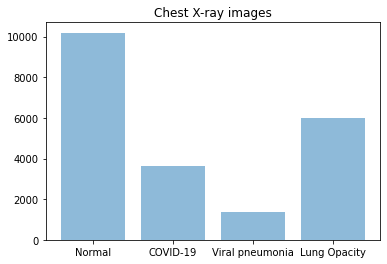

In [3]:
objects = ('Normal', 'COVID-19', 'Viral pneumonia', 'Lung Opacity')
y_pos = np.arange(len(objects))
performance = [len_normal, len_covid, len_viral_pneumonia, len_lung_opacity]

plt.bar(y_pos,performance, align='center', alpha=0.5)
plt.xticks(y_pos, objects)
plt.title('Chest X-ray images')

plt.show()

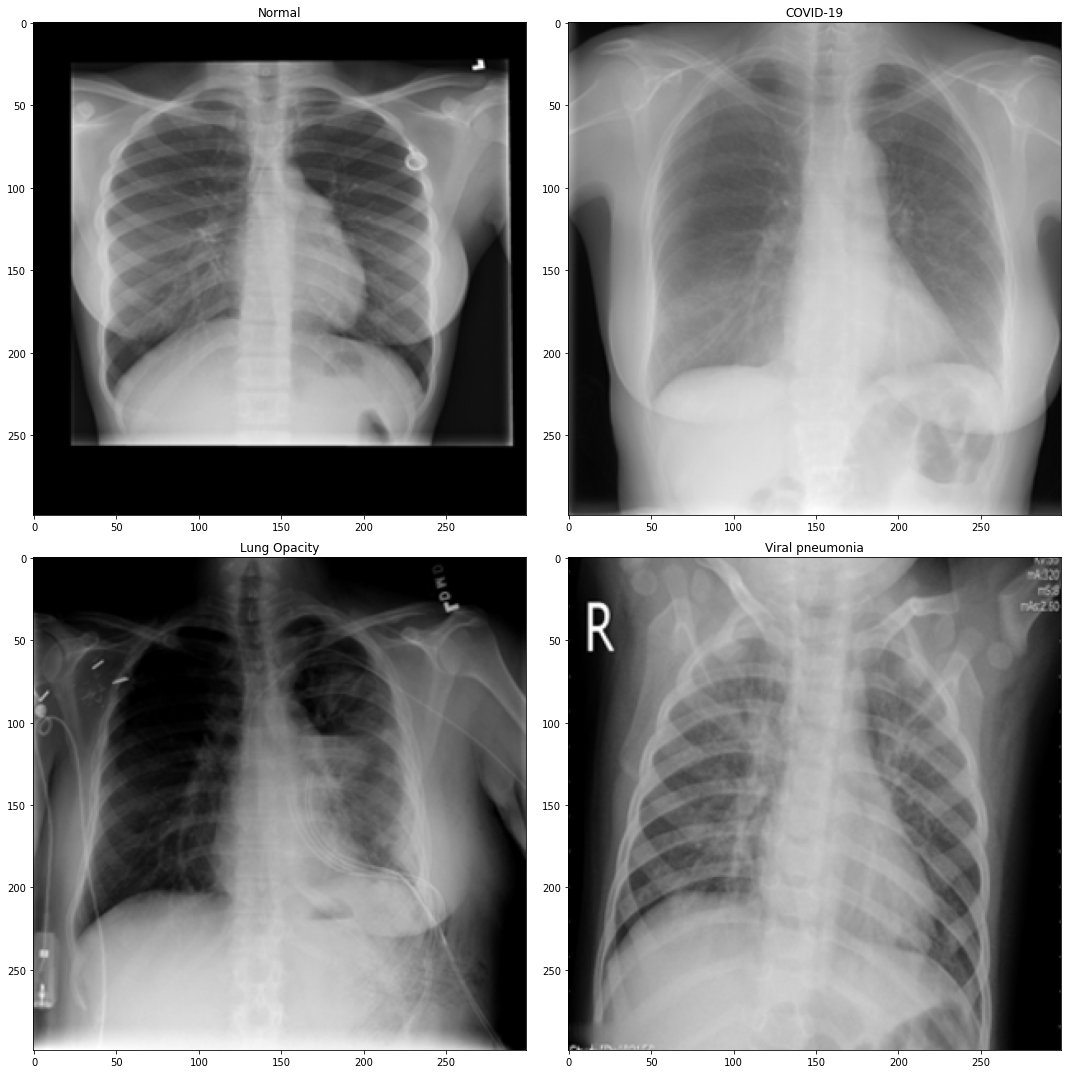

In [4]:
labels = ['Normal', 'COVID-19','Lung Opacity', 'Viral pneumonia']
img1 = path_normal+"/Normal-1.png"
img2 = path_covid+"/COVID-1994.png"
img3 = path_lung_opacity+"/Lung_Opacity-1.png"
img4 = path_viral_pneumonia + "/Viral Pneumonia-1.png"

imgs = [img1, img2, img3, img4]

fig, ax = plt.subplots(2, 2, figsize=(15, 15))
ax = ax.ravel()
plt.tight_layout()

for i in range(0,4):

    ax[i].imshow(plt.imread(imgs[i]), cmap='gray')
    ax[i].set_title(labels[i])

### Preprocess image

In [5]:
from PIL import Image, ImageOps
def resize_image(imgpath):
    img = np.array(ImageOps.colorize(Image.open(imgpath).resize((150,150), PIL.Image.Resampling.LANCZOS), black="black", white="white"))
    return img

In [6]:
import os
x_ = list()
y = list()

for i in os.listdir(path_normal):
    try:
        imgpath = path_normal+"/"+i
        img = resize_image(imgpath)
        x_.append(img)
        y.append(0)
    except:
        None
        
for i in os.listdir(path_covid):
    try:
        imgpath = path_covid+"/"+i
        img = resize_image(imgpath)
        x_.append(img)
        y.append(1)
    except:
        None
for i in os.listdir(path_lung_opacity):
    try:
        imgpath = path_lung_opacity+"/"+i
        img = resize_image(imgpath)
        x_.append(img)
        y.append(2)
    except:
        None
for i in os.listdir(path_viral_pneumonia):
    try:
        imgpath = path_viral_pneumonia+"/"+i
        img = resize_image(imgpath)
        x_.append(img)
        y.append(3)
    except:
        None
x_ = np.array(x_)

> ### Split dataset to train, validation, test

In [7]:
# from keras.utils.np_utils import to_categorical
# y = to_categorical(y,num_classes = 4)

classNames = ["normal","COVID_19", "lung_opacity","viral_pneumonia"]
print(classNames)

['normal', 'COVID_19', 'lung_opacity', 'viral_pneumonia']


In [8]:
from sklearn.model_selection import train_test_split

x_train,x_test,y_train,y_test = train_test_split(x_,y,test_size = 0.2,random_state = 20)

x_train,x_val,y_train,y_val = train_test_split(x_train,y_train,test_size = 0.1,random_state = 40)

In [9]:
print(x_train.shape)
y_train = np.asarray(y_train)
y_val = np.asarray(y_val)
y_test = np.asarray(y_test)
print(y_train.shape)

(15138, 150, 150, 3)
(15138,)


In [10]:
unique, counts = np.unique(y_train, return_counts=True)
uniqueVal, countsVal = np.unique(y_val, return_counts=True)
print(dict(zip(unique, counts)))
dict(zip(uniqueVal, countsVal))

{0: 7346, 1: 2611, 2: 4316, 3: 865}


{0: 807, 1: 293, 2: 475, 3: 107}

## ResNet Model

In [11]:
class ResidualUnit(keras.layers.Layer):
    def __init__(self, filters, strides=1, activation="selu", **kwargs):   
        super().__init__(**kwargs)
        self.activation = keras.activations.get(activation)                     #using "selu" activation function
        self.main_layers = [                                                    #defining main layers
            keras.layers.Conv2D(filters, 3, strides=strides,padding="same"),    #Adding convolution layers
            keras.layers.BatchNormalization(),                                  #Adding normalization layer
            self.activation,
            keras.layers.Conv2D(filters, 3, strides=1,padding="same"),
            keras.layers.BatchNormalization()]
        self.skip_layers = []
        if strides > 1: 
            self.skip_layers = [                                                #defining skip layer
                keras.layers.Conv2D(filters, 1, strides=strides,padding="same"),
                keras.layers.BatchNormalization()]
        
    def call(self, inputs):                                                     #call function
        Z = inputs
        for layer in self.main_layers:    
            Z = layer(Z)
        skip_Z = inputs
        for layer in self.skip_layers:
            skip_Z = layer(skip_Z)
        return self.activation(Z + skip_Z)                                      #activation function on skip layer

In [12]:
def ResNet_CNNModel():
    model = keras.models.Sequential()
    model.add(keras.layers.Conv2D(512, 7, strides=2, input_shape=np.shape(x_train[0]), padding="same"))
    model.add(keras.layers.BatchNormalization())
    model.add(keras.layers.Activation("selu"))
    model.add(keras.layers.Dropout(0.2))
    model.add(keras.layers.Conv2D(128, 3, strides=1, padding="same"))
    model.add(keras.layers.BatchNormalization())
    model.add(keras.layers.Activation("selu"))
    model.add(keras.layers.MaxPool2D(pool_size=3, strides=1, padding="same"))

    prev_filters = 128 
    for filters in [128]*2 + [64]*2:                    #Adding Residual Unit
        strides = 1 if filters == prev_filters else 2
        model.add(ResidualUnit(filters, strides=2))
        prev_filters = filters

    model.add(keras.layers.Flatten())
    model.add(keras.layers.Dense(128,activation = 'selu'))
    model.add(keras.layers.Dropout(0.4))
    model.add(keras.layers.Dense(64,activation = 'selu'))
    model.add(keras.layers.Dropout(0.3))
    model.add(keras.layers.Dense(4, activation="softmax"))
    
    model.compile(loss='sparse_categorical_crossentropy', optimizer = keras.optimizers.Adam(), metrics=['accuracy'])         #"Adam" optimizer is used
    
    return model

2022-10-03 14:56:30.900969: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-10-03 14:56:30.909609: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-10-03 14:56:30.910378: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-10-03 14:56:30.912147: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

Summary of ResNet CNN Model:-
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 75, 75, 512)       75776     
_________________________________________________________________
batch_normalization (BatchNo (None, 75, 75, 512)       2048      
_________________________________________________________________
activation (Activation)      (None, 75, 75, 512)       0         
_________________________________________________________________
dropout (Dropout)            (None, 75, 75, 512)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 75, 75, 128)       589952    
_________________________________________________________________
batch_normalization_1 (Batch (None, 75, 75, 128)       512       
_________________________________________________________________
activation_1 (Activation) 

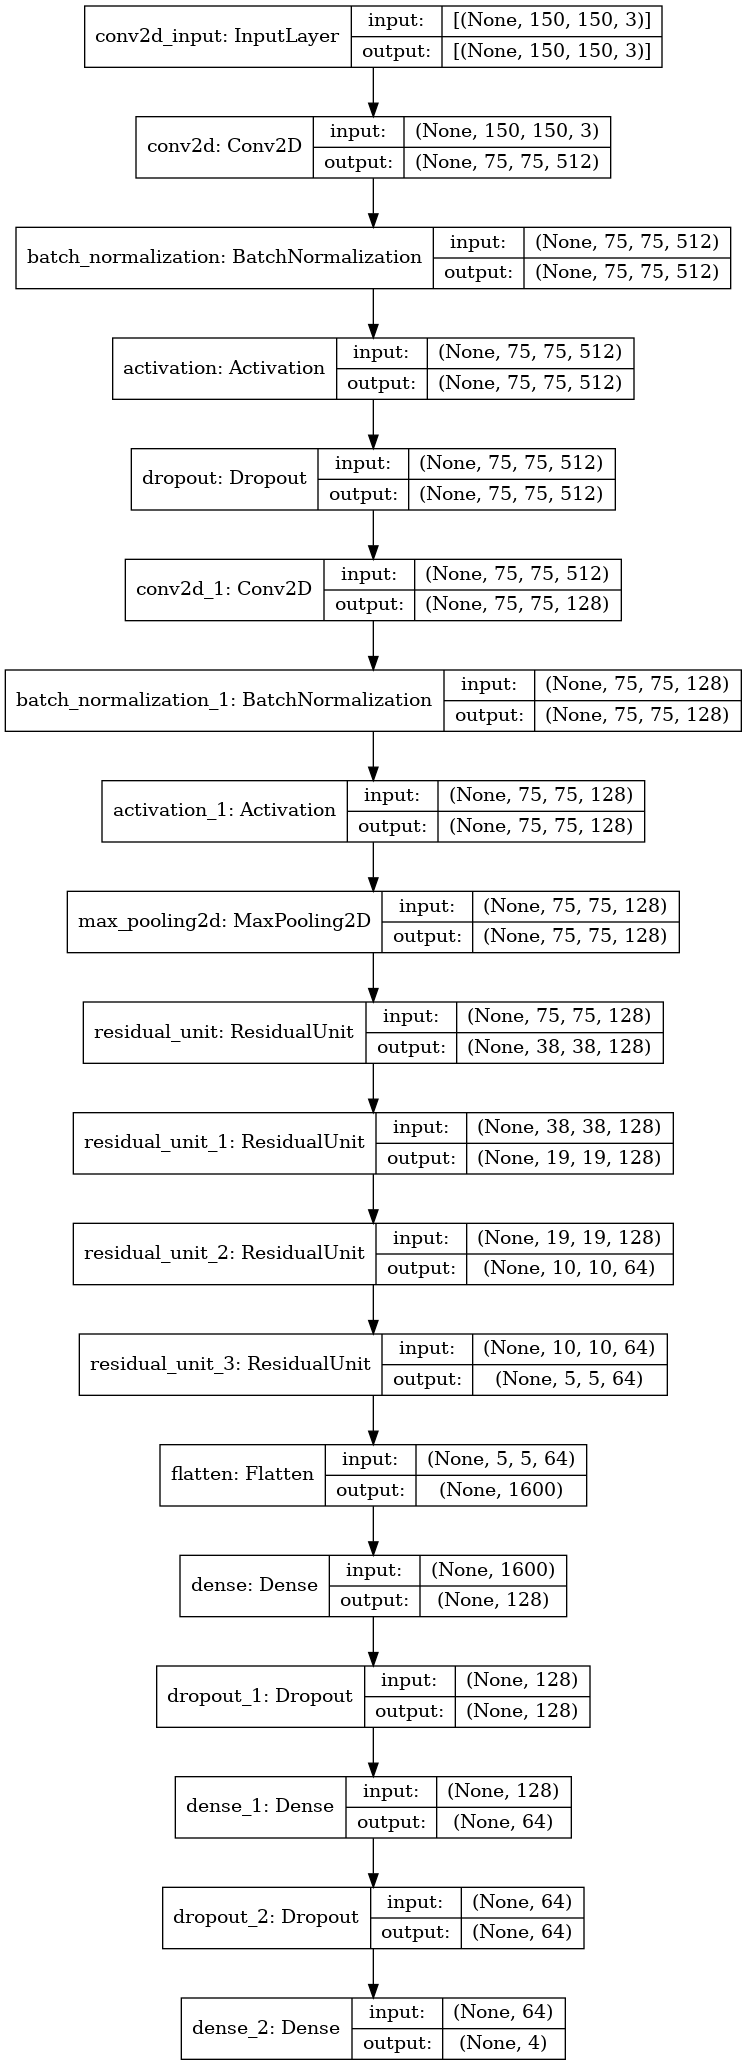

In [13]:
ResNetmodel = ResNet_CNNModel()
print('Summary of ResNet CNN Model:-')
ResNetmodel.summary()
tf.keras.utils.plot_model(ResNetmodel,to_file='model.png', show_shapes=True, show_layer_names=True)

### Training of ResNetModel and saving model_weights at each epoch**

In [14]:
checkpoint_path_resnet = 'training_1/resnet.ckpt'
checkpoint_dir = os.path.dirname(checkpoint_path_resnet)

cp_callback = tf.keras.callbacks.ModelCheckpoint(checkpoint_path_resnet,                          #callback for saving models at each epoch
                                                save_weights_only=True,
                                                monitor = 'val_accuracy',
                                                mode = 'max',
                                                save_best_only=True,
                                                verbose=1)
early = EarlyStopping(monitor='val_accuracy', mode='min', patience=20)
learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy', patience = 3, cooldown=0, verbose=1,factor=0.3, min_lr=0.000001)
callbacks_list = [cp_callback, early, learning_rate_reduction]

ResNetmodel_hist = ResNetmodel.fit(x_train, y_train, epochs = 50, batch_size = 32, validation_data = (x_val, y_val), callbacks = callbacks_list)

2022-10-03 14:56:40.436957: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 1021815000 exceeds 10% of free system memory.
2022-10-03 14:56:41.628615: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 1021815000 exceeds 10% of free system memory.
2022-10-03 14:56:42.483298: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/50


2022-10-03 14:56:44.241779: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


474/474 [==============================] - 56s 112ms/step - loss: 1.1489 - accuracy: 0.6266 - val_loss: 0.6242 - val_accuracy: 0.7551

Epoch 00001: val_accuracy improved from -inf to 0.75505, saving model to training_1/resnet.ckpt
Epoch 2/50
474/474 [==============================] - 52s 110ms/step - loss: 0.7025 - accuracy: 0.7309 - val_loss: 0.5335 - val_accuracy: 0.7990

Epoch 00002: val_accuracy improved from 0.75505 to 0.79905, saving model to training_1/resnet.ckpt
Epoch 3/50
474/474 [==============================] - 52s 110ms/step - loss: 0.5558 - accuracy: 0.7900 - val_loss: 0.6860 - val_accuracy: 0.7206

Epoch 00003: val_accuracy did not improve from 0.79905
Epoch 4/50
474/474 [==============================] - 52s 110ms/step - loss: 0.4860 - accuracy: 0.8138 - val_loss: 0.4389 - val_accuracy: 0.8282

Epoch 00004: val_accuracy improved from 0.79905 to 0.82818, saving model to training_1/resnet.ckpt
Epoch 5/50
474/474 [==============================] - 52s 110ms/step - loss: 0

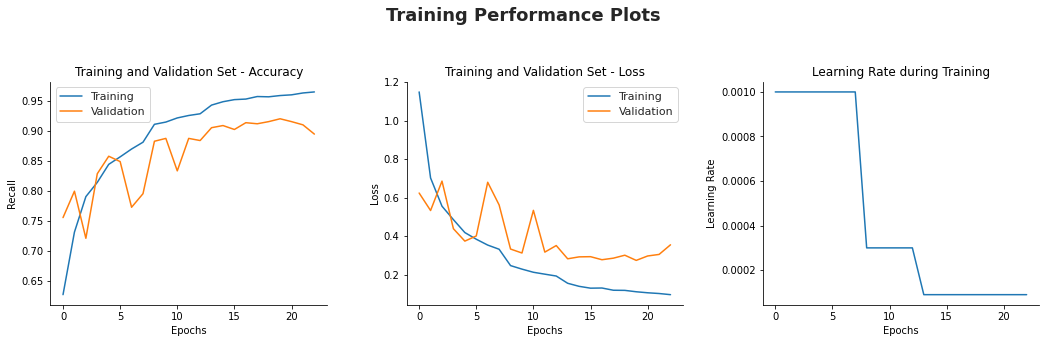

In [15]:
import seaborn as sns

#Plot training and validation Loss
fig, axarr = plt.subplots(1,3, figsize=(15,5),sharex=True)

sns.set(style="ticks", font_scale = 1)
sns.despine(top=True, right=True, left=False, bottom=False)

historyDF = pd.DataFrame.from_dict(ResNetmodel_hist.history)

ax = sns.lineplot(x =historyDF.index, y = ResNetmodel_hist.history['accuracy'],ax=axarr[0],label="Training");
ax = sns.lineplot(x =historyDF.index, y = ResNetmodel_hist.history['val_accuracy'],ax=axarr[0],label="Validation");
ax.set_ylabel('Recall')

ax = sns.lineplot(x =historyDF.index, y = ResNetmodel_hist.history['loss'],ax=axarr[1],label="Training");
ax = sns.lineplot(x =historyDF.index, y = ResNetmodel_hist.history['val_loss'],ax=axarr[1],label="Validation");
ax.set_ylabel('Loss')
ax = sns.lineplot(x =historyDF.index, y = ResNetmodel_hist.history['lr'],ax=axarr[2]);
ax.set_ylabel('Learning Rate')    
axarr[0].set_title("Training and Validation Set - Accuracy")
axarr[1].set_title("Training and Validation Set - Loss")
axarr[2].set_title("Learning Rate during Training")

for ax in axarr:
    ax.set_xlabel('Epochs')
    
plt.suptitle('Training Performance Plots',fontsize=18, weight = 'bold');
fig.tight_layout(pad=2.0)      
plt.show()

## Test and Evaluate Model

**Predict with test data**

In [16]:
# Get predictions
mypredict = ResNetmodel.predict(x_test)
pred = np.argmax(mypredict, axis=-1)
print(pred)

[0 2 2 ... 2 0 2]


In [17]:
evalute = ResNetmodel.evaluate(x_test, y_test)

132/132 [==============================] - 4s 34ms/step - loss: 0.3133 - accuracy: 0.9056


In [18]:
print("Accuracy: {:.2f}%".format(evalute[-1] * 100))  
print("Loss: {}".format(evalute[0]))

Accuracy: 90.56%
Loss: 0.3132520914077759


### Confusion matrix & Classification report

<AxesSubplot:>

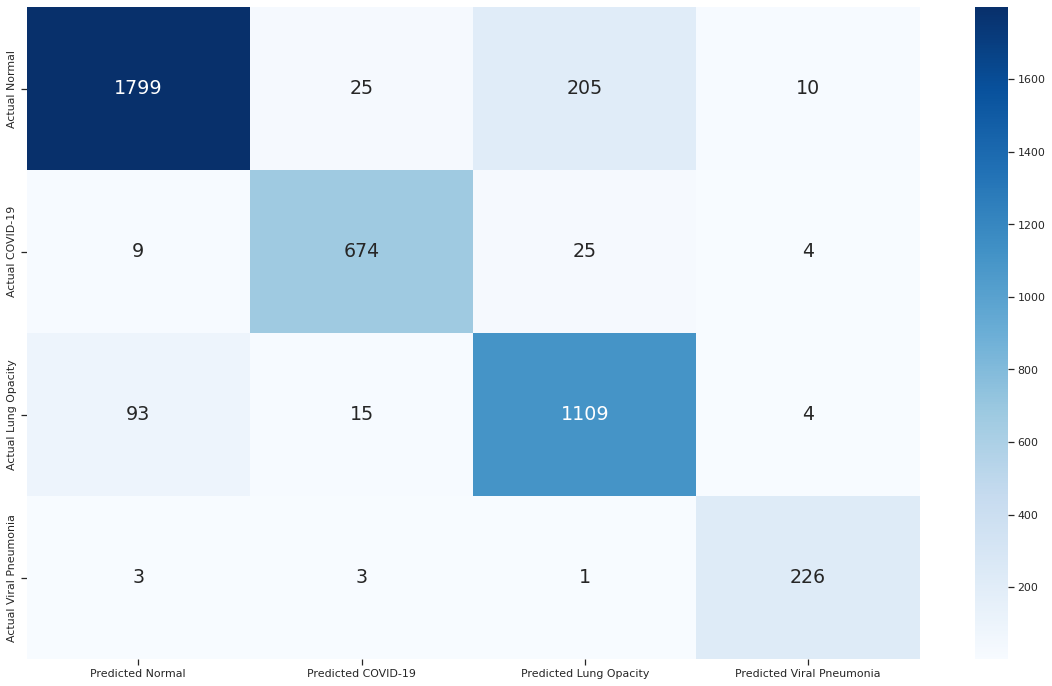

In [19]:
# Example of a confusion matrix in Python
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score 
from sklearn.metrics import classification_report 


cm = pd.DataFrame(data=confusion_matrix(y_test, mypredict.argmax(axis=1), labels=[0,1,2,3]),index=["Actual Normal", "Actual COVID-19", "Actual Lung Opacity", "Actual Viral Pneumonia"],
columns=["Predicted Normal", "Predicted COVID-19", "Predicted Lung Opacity", "Predicted Viral Pneumonia"])
fig, ax = plt.subplots(figsize=(20,12))
plt.rcParams.update({'font.size': 19})
sns.heatmap(cm,cmap="Blues",annot=True,fmt="d",ax=ax)

In [20]:
print ('Accuracy Score :',accuracy_score(y_test, mypredict.argmax(axis=1)) )
print ('Report : ')
print (classification_report(y_test, mypredict.argmax(axis=1)) )

Accuracy Score : 0.9055885850178359
Report : 
              precision    recall  f1-score   support

           0       0.94      0.88      0.91      2039
           1       0.94      0.95      0.94       712
           2       0.83      0.91      0.87      1221
           3       0.93      0.97      0.95       233

    accuracy                           0.91      4205
   macro avg       0.91      0.93      0.92      4205
weighted avg       0.91      0.91      0.91      4205



# Show Result Prediction

if predicted label is equal to real label we can see the text and bar in blue.
if predicted label is not equal to real label we can see the text and bar in red.

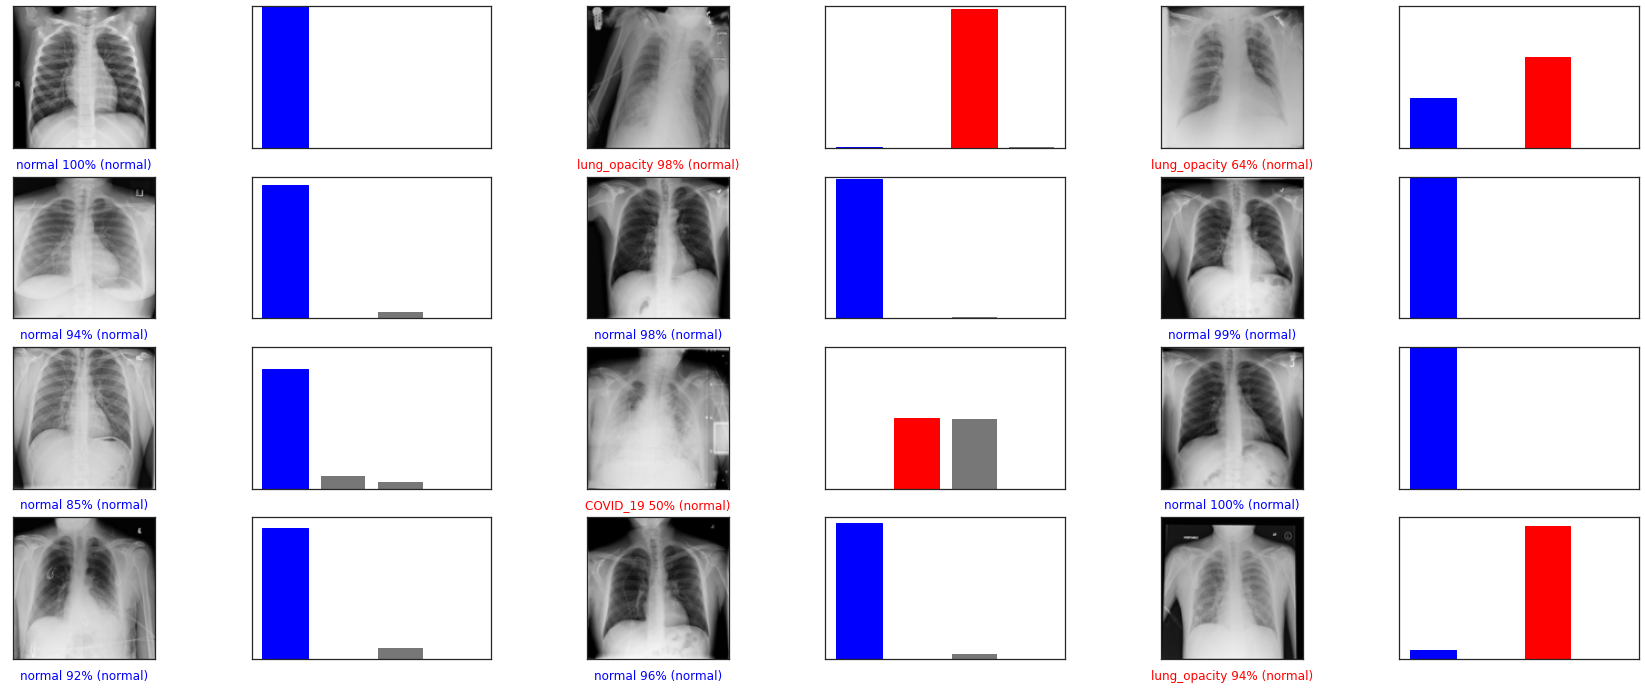

In [21]:
import matplotlib.pyplot as plt

def plot_value_array(i, predictions_array, true_label):
    predictions_array, true_label = predictions_array[i], true_label[i]
    plt.grid(False)
    plt.xticks([])
    plt.yticks([])
    thisplot = plt.bar(range(4), predictions_array, color="#777777")
    plt.ylim([0, 1])
    predicted_label = np.argmax(predictions_array)
    true_label = np.argmax(true_label)
    thisplot[predicted_label].set_color('red')
    thisplot[true_label].set_color('blue')

def plot_image(i, predictions_array, true_label, img):
    predictions_array, true_label, img = predictions_array[i], true_label[i], img[i]
    plt.grid(False)
    plt.xticks([])
    plt.yticks([])
    img = cv2.resize(img,(128,128))
    plt.imshow(img, cmap=plt.cm.binary)
    predicted_label = np.argmax(predictions_array)
    true_label= np.argmax(true_label)
    if predicted_label == true_label:
        color = 'blue'
    else:
        color = 'red'
  
    plt.xlabel("{} {:2.0f}% ({})".format(classNames[predicted_label],
                                100*np.max(predictions_array),
                                classNames[true_label]),
                                color=color)
    
def showResultPrediction(predictions):
    num_rows = 4
    num_cols = 3
    num_images = num_rows*num_cols
    plt.figure(figsize=(5*2*num_cols, 3*num_rows))
    for i in range(num_images):
      plt.subplot(num_rows, 2*num_cols, 2*i+1)
      plot_image(i, predictions, y_test, x_test)
      plt.subplot(num_rows, 2*num_cols, 2*i+2)
      plot_value_array(i, predictions, y_test)
    plt.show()

showResultPrediction(mypredict)

# References
https://www.kaggle.com/code/r0ckner/covid-19-classification-using-resnet-cnn-model